In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict
from typing import Optional, List, Tuple
import math
import sinter
import matplotlib
import rsmf 

formatter : plt.Formatter = rsmf.setup(r"\documentclass[a4paper,11pt,noarxiv]{quantumarticle}")
%matplotlib inline


# Functions for determining the teraquop volume

In [2]:
def get_sinter_fit(log_ps, sqrt_qs, target_x):
    if len(log_ps) < 2:
        print('error, less than 2 points')
        return None
    

    if len(set(log_ps)) == 1:
        print('error, all points are at same distance')
        return None
    
    slope_fit = sinter.fit_line_slope(
        xs=log_ps,
        ys=sqrt_qs,
        max_extra_squared_error=1,
    )
    
    if slope_fit.high >= 0:
    # Slope is going the wrong way! Definitely over threshold.
        print('error, slope is going the wrong way')
        return None

    fit = sinter.fit_line_y_at_x(
        xs=log_ps,
        ys=sqrt_qs,
        target_x=target_x,
        max_extra_squared_error=1,
    )
    return (fit)

def extrapolate_footprint_achieving_error_rate(
        group: List[sinter.TaskStats],
        target_p: float,
        data: str,
        
) -> Optional[sinter.Fit]:
    """Taken from Craig Gidney's code.
    
    Args:
        group: A list of TaskStats objects.
        target_p: The target probability of failure, for teraquop use 1e-12.

    Returns:
        A Fit object representing the footprint that would achieve the target
        probability of failure, or None if the data was insufficient.
    """
    assert len({stat.json_metadata['per'] for stat in group}) == 1
    sqrt_qs = []
    log_ps = []
    for stat in group:
        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.5:

                p_unit = p_shot
                sqrt_qs.append(math.sqrt(stat.json_metadata[data]**2)) 
                log_ps.append(math.log(p_unit))
            

    return get_sinter_fit(log_ps, sqrt_qs, math.log(target_p))

def calc_teraquop_patch_diameter(stats,metric):
  
    code_name_groups = sinter.group_by(stats, key = lambda stat: (stat.json_metadata['code_name'], stat.json_metadata['gf_0'], stat.json_metadata['gf_1'], stat.json_metadata['gf_2']))

    footprints = defaultdict()
    for code_name_key, code_name_group in code_name_groups.items(): 
        footprints[code_name_key] = extrapolate_footprint_achieving_error_rate(
                code_name_group,
                10**(-12),
                metric)
        if footprints[code_name_key] == None:
            print('error, no footprints')
            print(code_name_key)
            print(code_name_group)
    return(footprints)


def calc_xz_hight(x_hights_stability, z_hights_stability):

    xz_hight = dict()
    for code_name, x_hight in x_hights_stability.items():

        if code_name in z_hights_stability:
            z_hight = z_hights_stability[code_name]
        else:
            z_hight = None

        if x_hight != None and z_hight != None:

            xz_hight[code_name] = sinter.Fit(low = (x_hight.low + z_hight.low)/2,
                                            best = (x_hight.best + z_hight.best)/2,
                                            high = (x_hight.high + z_hight.high)/2)
            

    return(xz_hight)

def low_error_for_multiplication(values, max_values):
    relative_error = 0
    abs_value = 1
    for value, max_value in zip(values, max_values):
        relative_error += (abs(max_value-value)/value)**2
        abs_value *= value
    
    relative_error = math.sqrt(relative_error)
    return(abs_value*(1-relative_error))

def high_error_for_multiplication(values, max_values):
    relative_error = 0
    abs_value = 1
    for value, max_value in zip(values, max_values):
        relative_error += (abs(max_value-value)/value)**2
        abs_value *= value

    relative_error = math.sqrt(relative_error)

    return(abs_value*(1+relative_error))


def calc_volumes(x_patch_diameters, z_patch_diameters, xz_hight, factor):
    volumes = defaultdict()
    for code_name, x_patch_diameter in x_patch_diameters.items():
        if code_name in xz_hight and xz_hight[code_name] != None:
            if z_patch_diameters[code_name] != None and x_patch_diameter != None:
                low_fit = factor*low_error_for_multiplication([x_patch_diameter.best, z_patch_diameters[code_name].best, xz_hight[code_name].best], [x_patch_diameter.low, z_patch_diameters[code_name].low, xz_hight[code_name].low])
                high_fit = factor*high_error_for_multiplication([x_patch_diameter.best, z_patch_diameters[code_name].best, xz_hight[code_name].best], [x_patch_diameter.high, z_patch_diameters[code_name].high, xz_hight[code_name].high])

                volumes[code_name] = sinter.Fit(low=low_fit,
                        best= factor* x_patch_diameter.best * z_patch_diameters[code_name].best * xz_hight[code_name].best,
                        high=high_fit)

    return(volumes)


def get_diameter_hights_volumes(stats, noise_model):
    stats_nm = [stat for stat in stats if stat.json_metadata['noise_model'] == noise_model]

    stats_nm_memory_x = [stat for stat in stats_nm if stat.json_metadata['logical_observable']== 'memory_x']
    stats_nm_memory_z = [stat for stat in stats_nm if stat.json_metadata['logical_observable']== 'memory_z']
    stats_nm_stability_x = [stat for stat in stats_nm if stat.json_metadata['logical_observable']== 'stability_x']
    stats_nm_stability_z = [stat for stat in stats_nm if stat.json_metadata['logical_observable']== 'stability_z']


    
    x_sides = calc_teraquop_patch_diameter(stats_nm_memory_x, 'distance')
    z_sides = calc_teraquop_patch_diameter(stats_nm_memory_z, 'distance')
    x_hight = calc_teraquop_patch_diameter(stats_nm_stability_x, 'n_rounds')
    z_hight = calc_teraquop_patch_diameter(stats_nm_stability_z, 'n_rounds')
    xz_hights = calc_xz_hight(x_hight, z_hight)
    
    if noise_model == 'EM3':

        factor = 6 # n_E = 2*d_{s,E} , n_M = 3/2*d_{s,M}. N = 2n_E n_M = 6 d_{s,E} d_{s,M}
    else:
        factor = 15/4 # n_E = d_{s,E}, n_M = 3/4*d_{s,E}. N = 5 n_E n_M = 15/4 d_{s,E} d_{s,M}

    volumes = calc_volumes(x_sides, z_sides, xz_hights, factor)

    return(x_sides, z_sides, x_hight, z_hight, xz_hights, volumes)

# Functions for generating teraquop volume plots

In [3]:
def float_to_color_shade(value: int, color_map: matplotlib.colors.LinearSegmentedColormap, vmin=200, vmax=3000):
    # Normalize the value to the range [0, 1]
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    normalized_value = norm(value)

    # Get the color corresponding to the normalized value
    color : Tuple[int,int,int,int]= color_map(normalized_value)
    return color


def format_code_label(code_name):
    code_name_to_label = {
        'GaugeHoneycombCode': 'HCC',
        'GaugeFloquetColourCode': 'FCC'
    }
    if code_name_to_label.get(code_name[0], code_name) == 'HCC':
        return(f"$X^{code_name[1:][0]}Y^{code_name[1:][1]}Z^{code_name[1:][2]}$")
    else:
        return(f"$X^{code_name[1:][0]}Z^{code_name[1:][1]}$") 
    
def plot_footprints(footprints, ax=plt, top_n=10, vmin=10,vmax=80, y_label='Volume'):

    sorted_items = sorted(footprints.items(), key=lambda item: item[1].best if item[1] is not None else float('inf'))
    code_name_to_color = {'GaugeFloquetColourCode': plt.cm.Reds, 'GaugeHoneycombCode': plt.cm.Greens}
    for code_name, footprint in sorted_items[:top_n]:
        formatted_label = format_code_label(code_name)      
        if 1.2*float(footprint.high) < vmax:      
            bars = ax.bar(str(code_name), float(footprint.best), color = float_to_color_shade(footprint.best, code_name_to_color.get(code_name[0], 'black'), vmin=vmin, vmax=vmax))
            ax.errorbar(str(code_name), float(footprint.best), yerr=[[float(footprint.best - footprint.low)], [float(footprint.high - footprint.best)],], fmt='o', color='black', ecolor='black', elinewidth=1, capsize=3)
            for bar in bars:
                height = 1.02 * footprint.high
                ax.text(bar.get_x() + bar.get_width() / 2.0, height, formatted_label, ha='center', va='bottom', rotation=90)

    ax.set_xticks([]) 
    
    formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
    formatter.fontsize = 11
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)

def create_plot(noise_rate_1, noise_rate_2, noise_rate_3, decoder, vmins, vmaxs):
    stats_sdn : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/sdn_{noise_rate_1}.csv')
    stats_SI1000 : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/si_{noise_rate_2}.csv')
    stats_EM3 : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/EM3_{noise_rate_3}.csv')

    stats_sdn = [stat for stat in stats_sdn if stat.decoder == decoder] 
    stats_SI1000 = [stat for stat in stats_SI1000 if stat.decoder == decoder]
    stats_EM3 = [stat for stat in stats_EM3 if stat.decoder == decoder]
    _,_,_,_,_, volumes_SD6 = get_diameter_hights_volumes(stats_sdn, "standard_depolarizing_noise")
    _,_,_,_,_, volumes_SI1000  = get_diameter_hights_volumes(stats_SI1000, 'SI1000')
    _,_,_,_,_, volumes_EM3 = get_diameter_hights_volumes(stats_EM3, 'EM3')

    fig = formatter.figure(wide=True, aspect_ratio=1.5)
    ax1, ax2, ax3 = fig.subplots(3,1)
    plot_footprints(volumes_SD6, ax=ax1, top_n=50, vmin = vmins[0],vmax = vmaxs[0])
    plot_footprints(volumes_SI1000, ax=ax2, top_n=30, vmin=vmins[1],vmax=vmaxs[1])
    plot_footprints(volumes_EM3, ax=ax3, top_n=30, vmin=vmins[2],vmax=vmaxs[2])

    if decoder == 'pymatching':
        decoder_name = 'MWPM'
    elif decoder == 'beliefmatching':
        decoder_name = 'Belief matching'
    ax1.set_title(f'{decoder_name}, SD noise, p={noise_rate_1}')
    ax1.set_ylabel(r'Teraquop volume')
    ax2.set_ylabel(r'Teraquop volume')
    ax1.set_ylim(0, vmaxs[0])
    ax2.set_title(f'{decoder_name}, SI noise, p={noise_rate_2}')
    ax2.set_ylim(0, vmaxs[1])
    ax3.set_title(f'{decoder_name}, EM noise, p={noise_rate_3}')
    ax3.set_ylabel(r'Teraquop volume')
    ax3.set_ylim(0, vmaxs[2])

    plt.savefig(f"plots/volumes_cln_{noise_rate_1}_{noise_rate_2}_{noise_rate_3}_{decoder}.pdf", bbox_inches='tight')


# Generating Figure 3 

error, slope is going the wrong way
error, no footprints
('GaugeHoneycombCode', 3, 2, 1)
[sinter.TaskStats(strong_id='a5923f2cbb670fc2131f2a53fa0b80d7d58bd345805ca5d9098421866160f069', decoder='pymatching', json_metadata={'code_name': 'GaugeHoneycombCode', 'distance': 4, 'gf_0': 3, 'gf_1': 2, 'gf_2': 1, 'logical_observable': 'stability_x', 'n_rounds': 18, 'noise_model': 'EM3', 'per': 0.0025}, shots=1584, errors=103, seconds=0.08499999999999999), sinter.TaskStats(strong_id='98fc3cf740acd3ee937770884e79773e946e86178a8e2074b5fa7084d2c6897f', decoder='pymatching', json_metadata={'code_name': 'GaugeHoneycombCode', 'distance': 6, 'gf_0': 3, 'gf_1': 2, 'gf_2': 1, 'logical_observable': 'stability_x', 'n_rounds': 25, 'noise_model': 'EM3', 'per': 0.0025}, shots=1151, errors=102, seconds=0.121), sinter.TaskStats(strong_id='8147a6c3d229da38359a13d70a11ba09e8704238aeabcbf654de4069950395a6', decoder='pymatching', json_metadata={'code_name': 'GaugeHoneycombCode', 'distance': 8, 'gf_0': 3, 'gf_1': 2, 

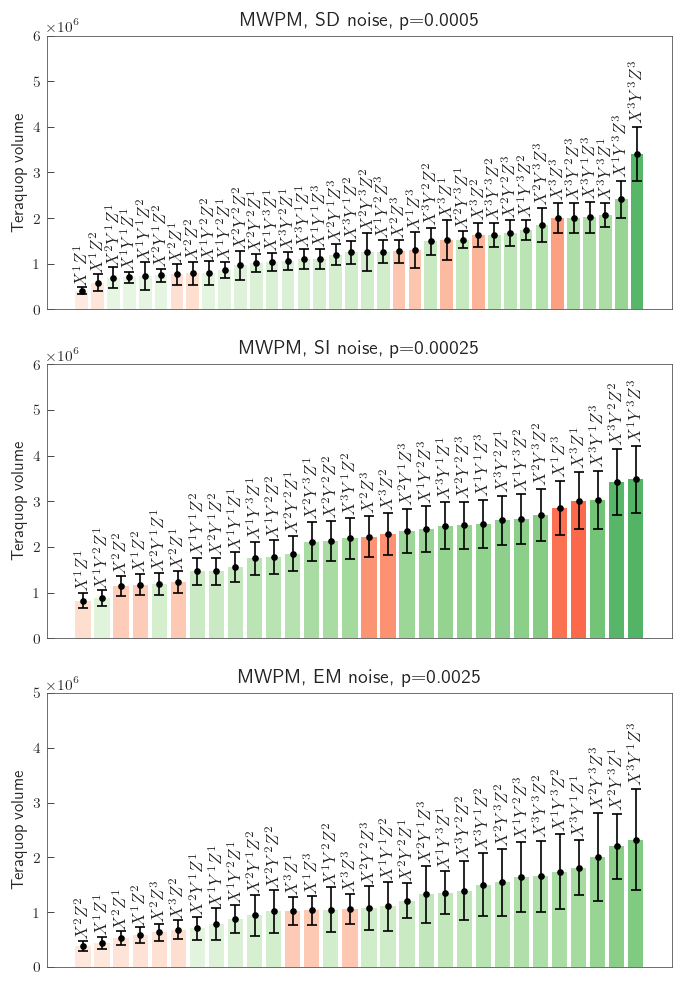

In [5]:
vmins = [10e3, 10e3, 10e3]
vmaxs = [6e6, 6e6, 5e6]
create_plot('0.0005', '0.00025', '0.0025', 'pymatching', vmins, vmaxs)

# Generating Figure 4

error, slope is going the wrong way
error, no footprints
('GaugeFloquetColourCode', 1, 3, 0)
[sinter.TaskStats(strong_id='ccea4f9224ebb97d1181a6dabafe91d6abaacad52827093e83f0b7ccab77caaf', decoder='beliefmatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 3, 'gf_2': 0, 'logical_observable': 'memory_x', 'n_rounds': 93, 'noise_model': 'SI1000', 'per': 0.0005}, shots=437, errors=15, seconds=31.78), sinter.TaskStats(strong_id='26faf5ecbb5f7c667196b4f6a57fe4779a9da7cbe930b79765941230e0c2ca93', decoder='beliefmatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 16, 'gf_0': 1, 'gf_1': 3, 'gf_2': 0, 'logical_observable': 'memory_x', 'n_rounds': 125, 'noise_model': 'SI1000', 'per': 0.0005}, shots=427, errors=13, seconds=118.1), sinter.TaskStats(strong_id='d9f769c5fd719515a8bf7d981c479a89a70a9c1ce84f6ad5418d6823f435175d', decoder='beliefmatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 4, 'gf_0': 1

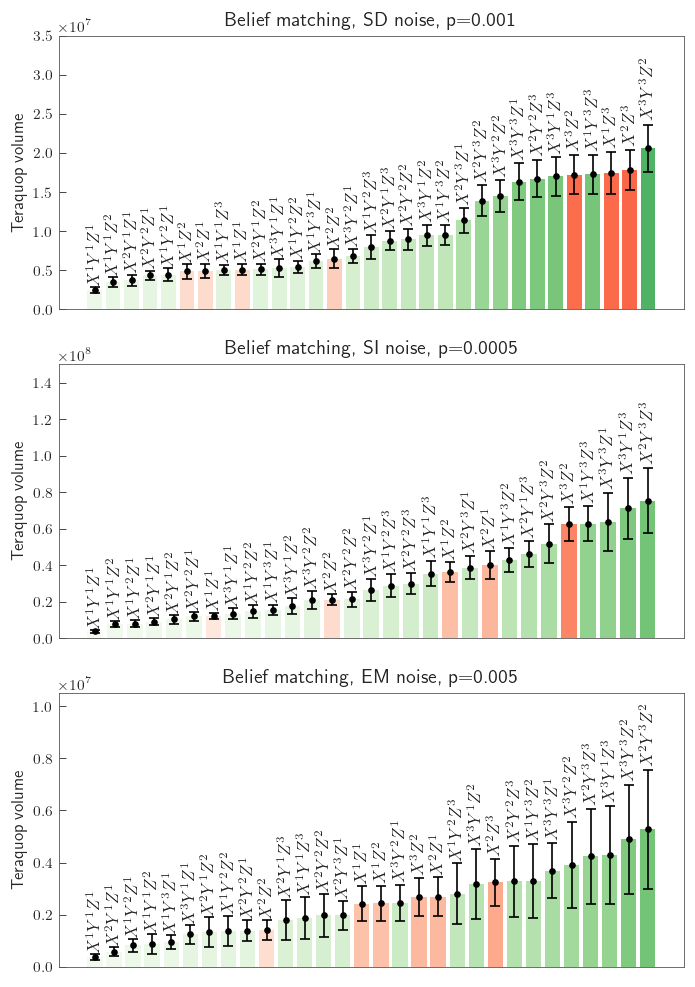

In [6]:
vmins = [10e3, 10e3, 10e3]
vmaxs = [3.5e7, 1.5e8, 1.05e7]
create_plot('0.001', '0.0005','0.005', 'beliefmatching', vmins, vmaxs)

# Functions for generating Figure 17

In [8]:
def plot_all_footprints_fcc_hcc(footprints_list_pm, footprint_list_bm, error_model, ax=plt, x_labels=[], vmin=10,vmax=80, y_label = 'Patch diameter'):
    pos = 0
    code_name_to_color = {'GaugeFloquetColourCode': 'Red', 'GaugeHoneycombCode': 'Green'}

    for footprints_pm, footprints_bm in zip(footprints_list_pm, footprint_list_bm):

        for code_name, footprint in footprints_pm.items():
            ax : plt.axes
            if footprint != None:
                bars = ax.bar(pos, float(footprint.best), color=code_name_to_color.get(code_name[0], 'black'), edgecolor='black')
                ax.errorbar(pos, float(footprint.best), yerr=[[float(footprint.best - footprint.low)], [float(footprint.high - footprint.best)],], fmt='o', color='black', ecolor='black', elinewidth=1, capsize=3)

            pos += 1
            bm_code_footprint = footprints_bm.get(code_name)
            bars = ax.bar(pos, float(bm_code_footprint.best), color=code_name_to_color.get(code_name[0], 'black'), edgecolor='black', hatch='x' )
            ax.errorbar(pos, float(bm_code_footprint.best), yerr=[[float(bm_code_footprint.best - bm_code_footprint.low)], [float(bm_code_footprint.high - bm_code_footprint.best)],], fmt='o', color='black', ecolor='black', elinewidth=1, capsize=3)
            pos += 1.2
        pos += 1

    formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
    formatter.fontsize = 11
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_labels) 

def filter_stats(stats, metadeta_entries: dict() = None, decoder = None):
    for metadeta_key, metadeta_value in metadeta_entries.items():
        stats = [stat for stat in stats if stat.json_metadata[metadeta_key] == metadeta_value]
    if decoder:
        stats = [stat for stat in stats if stat.decoder == decoder]
    return stats

# Generating Figure 18

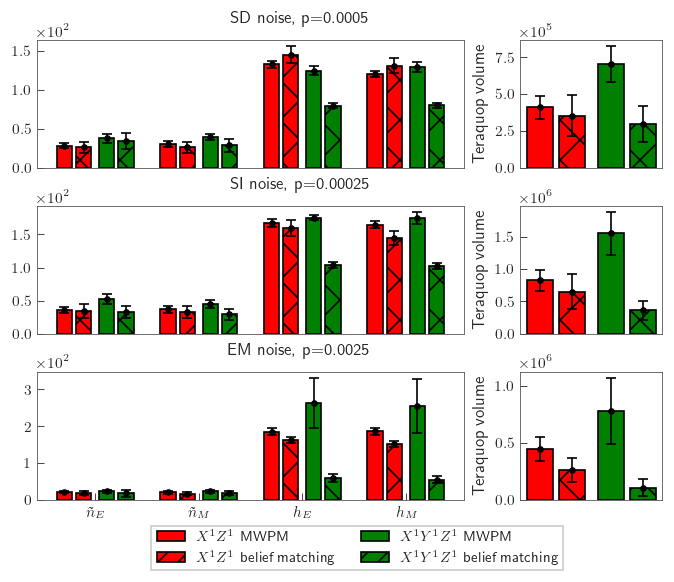

In [9]:

import matplotlib.patches as mpatches

fig = formatter.figure(wide=True)
subfigs = fig.subfigures(nrows=3, ncols=1)

x_labels = ['$\\tilde{n}_E$', '$\\tilde{n}_M$', '$h_E$', '$h_M$']

def gen_plot(axs, noise_model_name, noise_model):
    if noise_model_name == 'SD':
        stats : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/sdn_0.0005.csv')
    elif noise_model_name == 'SI1000':
        stats : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/si_0.00025.csv')
    else:
        stats : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/em3_0.0025.csv')

    stats_pm = filter_stats(stats, {'noise_model': noise_model, 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 0}, 'pymatching')
    stats_pm += filter_stats(stats, {'noise_model': noise_model, 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 1}, 'pymatching')
    stats_bm = filter_stats(stats, {'noise_model': noise_model, 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 0}, 'beliefmatching')
    stats_bm += filter_stats(stats, {'noise_model': noise_model, 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 1}, 'beliefmatching')

    x_sides, z_sides, x_hights, z_hights, _,volume_pm = get_diameter_hights_volumes(stats_pm, noise_model)
    x_sides_bm, z_sides_bm, x_hights_bm, z_hights_bm, _,volume_bm= get_diameter_hights_volumes(stats_bm, noise_model)
    plot_all_footprints_fcc_hcc([x_sides, z_sides, x_hights, z_hights], [x_sides_bm, z_sides_bm, x_hights_bm, z_hights_bm],'1.0,1.0,1.0,1.0', axs[0], y_label= '')
    plot_all_footprints_fcc_hcc([volume_pm],[volume_bm], '1.0,1.0,1.0,1.0', axs[1], y_label= 'Teraquop volume')


row_0 = subfigs[0].subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [3, 1]})
gen_plot(row_0, 'SD', 'standard_depolarizing_noise')

row_1 = subfigs[1].subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [3, 1]})
gen_plot(row_1, 'SI1000', 'SI1000')

row_2 = subfigs[2].subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [3, 1]})
gen_plot(row_2,  'EM3_0.0025', 'EM3')

subfigs[0].suptitle(f'SD noise, p=0.0005', y=1.05, x=0.45, fontsize='medium')
subfigs[1].suptitle(f'SI noise, p=0.00025', y=1.05, x=0.45, fontsize='medium')
subfigs[2].suptitle(f'EM noise, p=0.0025', y=1.05, x=0.45, fontsize='medium')


x_labels = ['$\\tilde{n}_E$', '$\\tilde{n}_M$', '$h_E$', '$h_M$']
row_2[0].set_xticks([1.6,7,12.375,17.8], x_labels)

red_patch_pm = mpatches.Patch(label='$X^1Z^1$ MWPM', edgecolor='black', facecolor='red')
red_patch_bm = mpatches.Patch(label='$X^1Z^1$ belief matching', edgecolor='black', hatch='//', facecolor='red')
green_patch_pm = mpatches.Patch(facecolor='green', label='$X^1Y^1Z^1$ MWPM', edgecolor='black')
green_patch_bm = mpatches.Patch(facecolor='green', label='$X^1Y^1Z^1$ belief matching', hatch='//', edgecolor='black')

row_2[0].legend(handles=[red_patch_pm, red_patch_bm, green_patch_pm, green_patch_bm], loc='upper center', bbox_to_anchor=(0.75, -0.15), ncol=2,  fontsize='small')

plt.savefig(f"plots/X1Y1Z1_X1Z1_comparison_cln.pdf", bbox_inches='tight')


## Additional plot not in paper

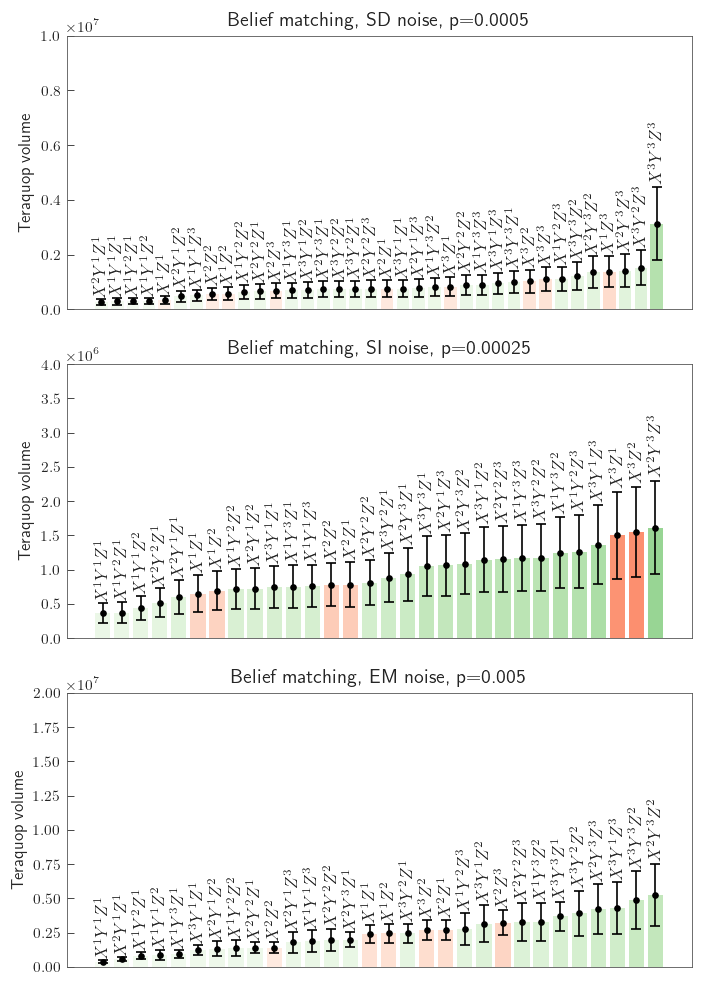

In [10]:
vmins = [10e2, 10e3, 10e3]
vmaxs = [1e7, 4e6, 2e7]
create_plot('0.0005', '0.00025','0.005', 'beliefmatching', vmins, vmaxs) 